In [1]:
import psycopg2
import json
from datetime import datetime as dt
import pandas as pd
import re 
from textblob import TextBlob 

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import re
import networkx as nx


In [2]:
p="datasucks"

In [4]:
conn = psycopg2.connect(user = "alexis",
                                  password = f"{p}",
                                  host = "127.0.0.1",
                                  port = "3306",
                                  database = "postgres")

In [5]:
cursor = conn.cursor()

In [6]:
tweet_list = []
followers = []
cursor.execute("select * from tweets")
tweets = cursor.fetchall()
if not tweets:
    print("empty")
for row in tweets:
    for col in row:
        if type(col) is dict:
            tweet_list.append(col['text'])
            followers.append(col['user']['followers_count'])

In [7]:
remove_list = [r'@[A-Za-z0-9]+','https?://[A-Za-z0-9./]+','\n','RT :',r'_[A-Za-z0-9]+','  ']

In [8]:
def clean_tweets(remove_list,tweet_list):
    for item in remove_list:
        tweet_list = [re.sub(item,'',tweet) for tweet in tweet_list]
    return tweet_list

In [48]:
cleaned = clean_tweets(remove_list,tweet_list)
# blob=TextBlob = cleaned
# blob
cleaned

['There are so many hilarious comments in You Tubechat on @ show tonight.',
 ' Democrat frontrunner Michael Bloomberg says he wants to make the whole country "behave" while dressed as Mary Poppins.Wel…',
 'The latest COACH!#election2020 #misleadingtweets',
 'THERE IS NO ONE TO VOTE FOR! Centrists demand Valium to get them through #Election2020',
 'RT : Calling all voters!! Are you ready for November?👉🏿RT to spread the word. 🗳️ #Election2020 http…',
 ' Team Warren! #PresidentWarren #DemocraticPrimaries #Election2020 ',
 'RT :#Election2020 Enjoy…',
 ' As a man and feminist I am flabbergasted at this Tweet from you. This says so much about your own bi… ',
 " It's $3 Thursday! I'm asking for everyone to help that is able to donate $3 to my campaign for Congress. Join us and help put p…",
 '2020 Presidential Election News Update🗞:2020 Democratic contenders plead for cash after draining their accounts… ',
 ' #Bloomberg is buying the Dem nomination *because* many resisters won’t support him👀‼

In [51]:
for each in cleaned:
    print(TextBlob(each))

There are so many hilarious comments in You Tubechat on @ show tonight.
 Democrat frontrunner Michael Bloomberg says he wants to make the whole country "behave" while dressed as Mary Poppins.Wel…
The latest COACH!#election2020 #misleadingtweets
THERE IS NO ONE TO VOTE FOR! Centrists demand Valium to get them through #Election2020
RT : Calling all voters!! Are you ready for November?👉🏿RT to spread the word. 🗳️ #Election2020 http…
 Team Warren! #PresidentWarren #DemocraticPrimaries #Election2020 
RT :#Election2020 Enjoy…
 As a man and feminist I am flabbergasted at this Tweet from you. This says so much about your own bi… 
 It's $3 Thursday! I'm asking for everyone to help that is able to donate $3 to my campaign for Congress. Join us and help put p…
2020 Presidential Election News Update🗞:2020 Democratic contenders plead for cash after draining their accounts… 
 #Bloomberg is buying the Dem nomination *because* many resisters won’t support him👀‼️His goal is to keep the #GOP in pow…
I wo

 Do you believe America would be better off if more Christians served in elected office?#Retweet #Poll #Election2020 #…
 Do you believe America would be better off if more Christians served in elected office?#Retweet #Poll #Election2020 #…
 The results of this poll so far are NOT indicative of any community I’ve ever lived in, or even visited 🤔🙄 Let’s vote!
 Russia commits a brutal cyberattack against the country of Georgia. Putin's Puppet DJT responds b…
 Do you believe America would be better off if more Christians served in elected office?#Retweet #Poll #Election2020 #…
 Come on ! This is UNBELIEVABLE ! Conservative Christians please help flip this Poll ! 🙏🙏#CCOT
 Ok Christians!We are not ashamed of the gospel and boldly proclaim our Lord and Savior Jesus.Let’s flip this poll.Ple…
 Come on ! This is UNBELIEVABLE ! Conservative Christians please help flip this Poll ! 🙏🙏#CCOT
 Do you believe America would be better off if more Christians served in elected office?#Retweet #Poll #Electi

In [11]:
sentiment_objects = []
for each in cleaned:
    sentiment_objects.append([(each),TextBlob(each).polarity, TextBlob(each).subjectivity])

    
sentiment_df = pd.DataFrame(sentiment_objects) 
sentiment_df.rename(columns = {0:"tweets", 1:"sentiment",2:"subjectivity"}, inplace=True)

sentiment_df.head()

,tweets,sentiment,subjectivity
0,There are so many hilarious comments in You Tu...,0.5,0.75
1,Democrat frontrunner Michael Bloomberg says h...,0.2,0.25
2,The latest COACH!#election2020 #misleadingtweets,0.5,0.90
3,THERE IS NO ONE TO VOTE FOR! Centrists demand ...,0.0,0.00
4,RT : Calling all voters!! Are you ready for No...,0.2,0.50


In [14]:
bins = [-1,-0.1,0.1,2]
labels = ['Negative', 'Neutral','Positive']
sentiment_df['type'] = pd.cut(sentiment_df['sentiment'], bins=bins, labels=labels)

In [34]:
sentiment_df.type.value_counts()

Neutral     1259
Positive     846
Negative     205
Name: type, dtype: int64

C:\Users\alexi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


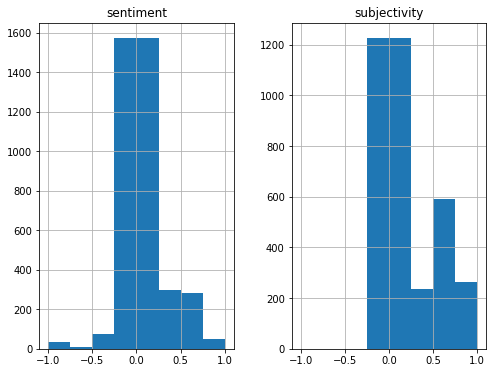

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],ax=ax)

plt.show()

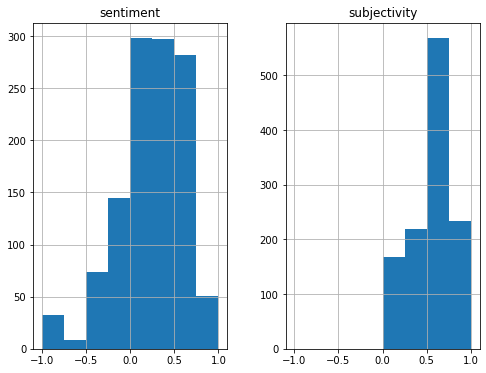

In [36]:
# Remove values equal to zero - better
sentiment_df = sentiment_df[sentiment_df.sentiment != 0]
sentiment_df = sentiment_df[sentiment_df.subjectivity != 0]

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],ax=ax)
plt.show()

In [37]:
# tokenized_tweet = sentiment_df['tweets'].apply(lambda x: x.split())
# tokenized_tweet.head()

words_in_tweet = [tweet.lower().split() for tweet in tweet_list]
# words_in_tweet

In [38]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection words
# collection_words = ['election', 'bernie', 'election2020',"trump","warren","biden"]

# tweets_nsw_nc = [[w for w in word if not w in collection_words]
#                  for word in tweets_nsw]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw]

# View bigrams for the first tweet
terms_bigram[0]

[('rt', '@bbydmplng403:'),
 ('@bbydmplng403:', '@louiselowrey'),
 ('@louiselowrey', 'many'),
 ('many', 'hilarious'),
 ('hilarious', 'comments'),
 ('comments', 'tube'),
 ('tube', '@patriotssoapbox'),
 ('@patriotssoapbox', 'chat'),
 ('chat', '@_saltycrystal'),
 ('@_saltycrystal', 'show'),
 ('show', 'tonight.')]

In [40]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('believe', 'america'), 162),
 (('america', 'would'), 162),
 (('would', 'better'), 162),
 (('#poll', '#election2020'), 162),
 (('#election2020', '#…'), 162),
 (('rt', '@christlawmakers:'), 161),
 (('@christlawmakers:', 'believe'), 161),
 (('better', 'christians'), 161),
 (('christians', 'served'), 161),
 (('served', 'elected'), 161),
 (('elected', 'office?'), 161),
 (('office?', '#retweet'), 161),
 (('#retweet', '#poll'), 161),
 (('rt', '@williewjewell:'), 113),
 (('persons', 'seeking'), 100),
 (('@williewjewell:', 'florida'), 99),
 (('florida', '@govrondesantis'), 99),
 (('@govrondesantis', 'requiring'), 99),
 (('requiring', 'persons'), 99),
 (('seeking', 'employment'), 99)]

In [41]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df.head()

,bigram,count
0,"(believe, america)",162
1,"(america, would)",162
2,"(would, better)",162
3,"(#poll, #election2020)",162
4,"(#election2020, #…)",162


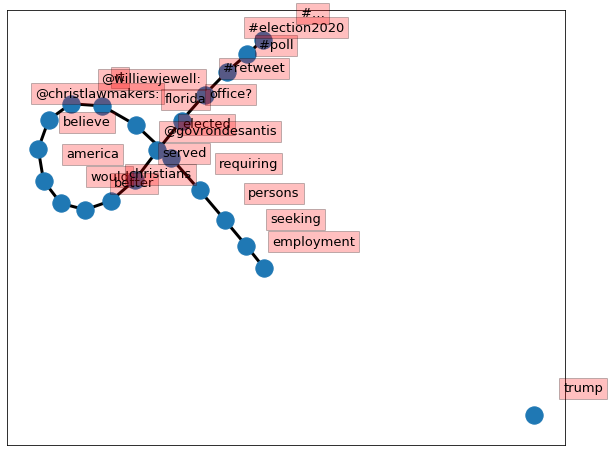

In [45]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("trump", weight=100)
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
#                  edge_color='grey',
#                  node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [46]:
all_words_no_urls = list(itertools.chain(*tweets_nsw))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)
counts_no_urls

Counter({'rt': 1486,
         '@bbydmplng403:': 1,
         '@louiselowrey': 1,
         'many': 19,
         'hilarious': 1,
         'comments': 9,
         'tube': 1,
         '@patriotssoapbox': 1,
         'chat': 1,
         '@_saltycrystal': 1,
         'show': 26,
         'tonight.': 2,
         '@danrodimer:': 1,
         'democrat': 15,
         'frontrunner': 5,
         'michael': 6,
         'bloomberg': 26,
         'says': 19,
         'wants': 18,
         'make': 53,
         'whole': 3,
         'country': 24,
         '"behave"': 1,
         'dressed': 1,
         'mary': 1,
         'poppins.': 1,
         'wel…': 1,
         'latest': 12,
         'coach!': 1,
         'https://t.co/sz1nofbzmk': 1,
         '#election2020': 592,
         '#misleadingtweets': 1,
         'one': 77,
         'vote': 108,
         'for!': 1,
         'centrists': 2,
         'demand': 1,
         'valium': 1,
         'get': 65,
         '@k_jeanpierre:': 2,
         'calling': 26,
 

In [47]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,rt,1486
1,#election2020,592
2,christians,217
3,would,213
4,better,201


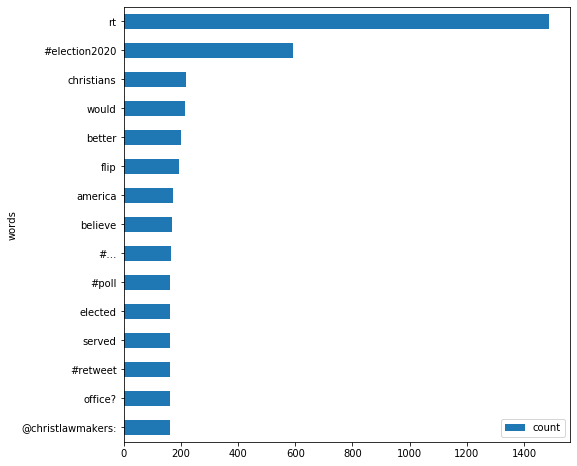

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax)

plt.show()

In [27]:
bins = [-1,-0.1,0.1,1]
labels = ['Negative', 'Neutral','Positive']
sentiment_df['type'] = pd.cut(sentiment_df['sentiment'], bins=bins, labels=labels)


sentiment_df.head()

,tweets,sentiment,subjectivity,type
0,There are so many hilarious comments in You Tu...,0.5,0.75,Positive
1,Democrat frontrunner Michael Bloomberg says h...,0.2,0.25,Positive
2,The latest COACH!#election2020 #misleadingtweets,0.5,0.90,Positive
4,RT : Calling all voters!! Are you ready for No...,0.2,0.50,Positive
7,As a man and feminist I am flabbergasted at t...,0.4,0.60,Positive


In [32]:
training = [(sentiment_df.tweets, sentiment_df.type)] 

In [33]:
from textblob import classifiers
classifier = classifiers.NaiveBayesClassifier(training)

In [52]:
## decision tree classifier
# dt_classifier = classifiers.DecisionTreeClassifier(training)

In [53]:
# # Need test data
# print (classifier.accuracy(testing))
# classifier.show_informative_features(3)